## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0731 20:59:12.131591  5132 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0731 20:59:12.133591  5132 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0731 20:59:12.161593  5132 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 20:59:12.162593  5132 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 20:59:12.165593  5132 deprecation_wrapper.py:119] From C:\Anaconda3\li

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0731 20:59:12.367604  5132 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 231us/step - loss: 198.7355 - acc: 0.2201 - val_loss: 41.1121 - val_acc: 0.2361
Epoch 2/50
50000/50000 [==============================] - 10s 197us/step - loss: 19.0967 - acc: 0.1122 - val_loss: 7.2738 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 10s 196us/step - loss: 4.0971 - acc: 0.0983 - val_loss: 2.6450 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 10s 191us/step - loss: 2.4855 - acc: 0.0961 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 10s 205us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 9s 185us/step - loss: 2.4626 - acc: 0.0992 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 9s 185us/step - loss: 2.4626 - acc: 0.0962 - val_loss: 

Epoch 2/50
50000/50000 [==============================] - 9s 179us/step - loss: 5.7281 - acc: 0.3642 - val_loss: 5.6532 - val_acc: 0.3742
Epoch 3/50
50000/50000 [==============================] - 9s 179us/step - loss: 5.5750 - acc: 0.3949 - val_loss: 5.5077 - val_acc: 0.4104
Epoch 4/50
50000/50000 [==============================] - 9s 180us/step - loss: 5.4522 - acc: 0.4170 - val_loss: 5.3989 - val_acc: 0.4238
Epoch 5/50
50000/50000 [==============================] - 9s 180us/step - loss: 5.3453 - acc: 0.4331 - val_loss: 5.3075 - val_acc: 0.4278
Epoch 6/50
50000/50000 [==============================] - 9s 182us/step - loss: 5.2460 - acc: 0.4442 - val_loss: 5.2057 - val_acc: 0.4425
Epoch 7/50
50000/50000 [==============================] - 9s 180us/step - loss: 5.1531 - acc: 0.4549 - val_loss: 5.1284 - val_acc: 0.4479
Epoch 8/50
50000/50000 [==============================] - 9s 181us/step - loss: 5.0646 - acc: 0.4650 - val_loss: 5.0538 - val_acc: 0.4516
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 9s 179us/step - loss: 1.7370 - acc: 0.3920 - val_loss: 1.7020 - val_acc: 0.4025
Epoch 4/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.6762 - acc: 0.4139 - val_loss: 1.6569 - val_acc: 0.4150
Epoch 5/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.6269 - acc: 0.4294 - val_loss: 1.6129 - val_acc: 0.4325
Epoch 6/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5877 - acc: 0.4425 - val_loss: 1.5850 - val_acc: 0.4467
Epoch 7/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5518 - acc: 0.4559 - val_loss: 1.5473 - val_acc: 0.4592
Epoch 8/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5228 - acc: 0.4659 - val_loss: 1.5363 - val_acc: 0.4558
Epoch 9/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.4948 - acc: 0.4748 - val_loss: 1.5084 - val_acc: 0.4682
Epoch 10/50
50000/50000 [====================

50000/50000 [==============================] - 9s 179us/step - loss: 1.6640 - acc: 0.4169 - val_loss: 1.6384 - val_acc: 0.4270
Epoch 5/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.6152 - acc: 0.4353 - val_loss: 1.6009 - val_acc: 0.4427
Epoch 6/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5744 - acc: 0.4488 - val_loss: 1.5774 - val_acc: 0.4487
Epoch 7/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.5410 - acc: 0.4597 - val_loss: 1.5512 - val_acc: 0.4551
Epoch 8/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.5117 - acc: 0.4682 - val_loss: 1.5291 - val_acc: 0.4596
Epoch 9/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.4855 - acc: 0.4778 - val_loss: 1.5041 - val_acc: 0.4656
Epoch 10/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.4596 - acc: 0.4880 - val_loss: 1.4864 - val_acc: 0.4745
Epoch 11/50
50000/50000 [===================

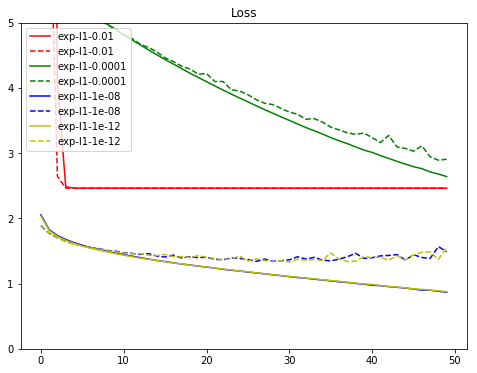

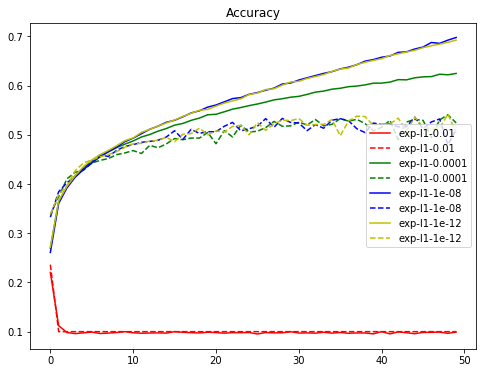

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [13]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
results2={}
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results2[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 261us/step - loss: 18.8011 - acc: 0.2697 - val_loss: 17.3542 - val_acc: 0.3290
Epoch 2/50
50000/50000 [==============================] - 13s 253us/step - loss: 16.1398 - acc: 0.3576 - val_loss: 14.9880 - val_acc: 0.3611
Epoch 3/50
50000/50000 [==============================] - 12s 242us/step - loss: 13.9573 - acc: 0.3773 - val_loss: 12.9758 - val_acc: 0.3917
Epoch 4/50
50000/50000 [==============================] - 12s 242us/step - loss: 12.1111 - acc: 0.3898 - val_loss: 11.2769 - val_acc: 0.3970
Epoch 5/50
50000/50000 [==============================] - 12s 246us/step - loss: 10.5397 - acc: 0.4006 - val_loss: 9.8311 - val_acc: 0.4037
Epoch 6/50
50000/50000 [==============================] - 12s 244us/step - loss: 9.2005 - acc: 0.4088 - val_loss: 8.5978 - val_acc: 0.4101
Epoch 7/50
50000/50000 [==============================] - 12s 242us/step - loss: 8.0609 - acc: 0.4148 - val

50000/50000 [==============================] - 11s 224us/step - loss: 15.1267 - acc: 0.2564 - val_loss: 13.9931 - val_acc: 0.3212
Epoch 2/50
50000/50000 [==============================] - 11s 215us/step - loss: 13.0511 - acc: 0.3452 - val_loss: 12.1549 - val_acc: 0.3622
Epoch 3/50
50000/50000 [==============================] - 11s 215us/step - loss: 11.3723 - acc: 0.3724 - val_loss: 10.6284 - val_acc: 0.3733
Epoch 4/50
50000/50000 [==============================] - 11s 215us/step - loss: 9.9564 - acc: 0.3863 - val_loss: 9.3150 - val_acc: 0.3923
Epoch 5/50
50000/50000 [==============================] - 11s 215us/step - loss: 8.7522 - acc: 0.3968 - val_loss: 8.2076 - val_acc: 0.4025
Epoch 6/50
50000/50000 [==============================] - 11s 215us/step - loss: 7.7271 - acc: 0.4055 - val_loss: 7.2594 - val_acc: 0.4090
Epoch 7/50
50000/50000 [==============================] - 11s 215us/step - loss: 6.8521 - acc: 0.4118 - val_loss: 6.4568 - val_acc: 0.4242
Epoch 8/50
50000/50000 [========

Epoch 2/50
50000/50000 [==============================] - 15s 302us/step - loss: 13.0087 - acc: 0.3606 - val_loss: 12.1175 - val_acc: 0.3729
Epoch 3/50
50000/50000 [==============================] - 13s 262us/step - loss: 11.3364 - acc: 0.3832 - val_loss: 10.5820 - val_acc: 0.3905
Epoch 4/50
50000/50000 [==============================] - 13s 257us/step - loss: 9.9261 - acc: 0.3975 - val_loss: 9.2897 - val_acc: 0.4000
Epoch 5/50
50000/50000 [==============================] - 14s 271us/step - loss: 8.7272 - acc: 0.4082 - val_loss: 8.1824 - val_acc: 0.4137
Epoch 6/50
50000/50000 [==============================] - 11s 229us/step - loss: 7.7056 - acc: 0.4171 - val_loss: 7.2411 - val_acc: 0.4198
Epoch 7/50
50000/50000 [==============================] - 11s 226us/step - loss: 6.8337 - acc: 0.4231 - val_loss: 6.4406 - val_acc: 0.4244
Epoch 8/50
50000/50000 [==============================] - 11s 226us/step - loss: 6.0897 - acc: 0.4299 - val_loss: 5.7514 - val_acc: 0.4323
Epoch 9/50
50000/50000 

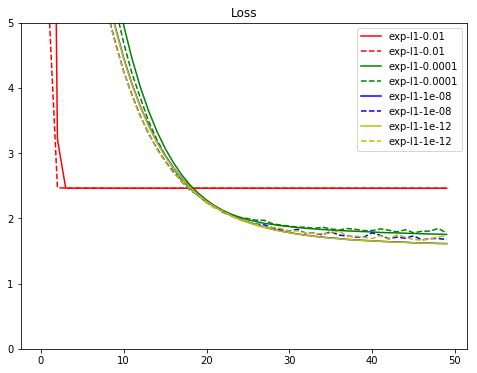

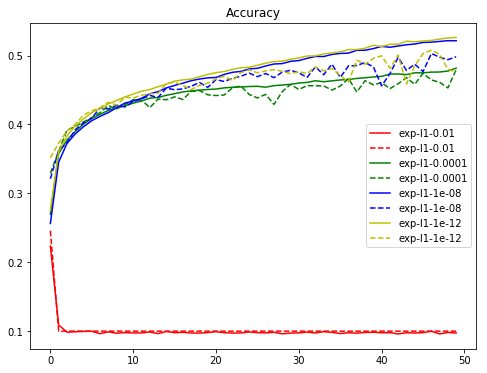

In [16]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results2[cond]['train-loss'])),results2[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-loss'])),results2[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results2[cond]['train-acc'])),results2[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-acc'])),results2[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()